In [0]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
!pip install catboost
from catboost import CatBoostClassifier,CatBoostRegressor

     |████████████████████████████████| 62.9MB 131kB/s 


## Import necessary python libraries for EDA

In [0]:
import pandas as pd
import numpy as np
np.random.seed(643)
import matplotlib.pyplot as plt

# Load csv file from my google drive account

There is a public folder in my google drive account wherein i have stored student csv file. Shareable link for downloading it from there is https://drive.google.com/open?id=14NPp9XNtTuoWxv_jEFMkwl3Eatl5hvtq . <br>
one can see this file just by clicking on the above link and can import into google colaboratory after authentication.

In [0]:
# import csv file from google drive via Pydrive
! pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate and create pydrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:

# now we'll use shareable link to import csv file
s_link = 'https://drive.google.com/open?id=14NPp9XNtTuoWxv_jEFMkwl3Eatl5hvtq'
# we need only id portion of the shareable link
flush,id_portion = s_link.split('=')
print(id_portion)

14NPp9XNtTuoWxv_jEFMkwl3Eatl5hvtq


In [0]:
download = drive.CreateFile({'id':id_portion})

In [0]:
download.GetContentFile('student-por.csv')

In [0]:
df = pd.read_csv('student-por.csv',sep=';')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


In [0]:
df.count()

school        649
sex           649
age           649
address       649
famsize       649
Pstatus       649
Medu          649
Fedu          649
Mjob          649
Fjob          649
reason        649
guardian      649
traveltime    649
studytime     649
failures      649
schoolsup     649
famsup        649
paid          649
activities    649
nursery       649
higher        649
internet      649
romantic      649
famrel        649
freetime      649
goout         649
Dalc          649
Walc          649
health        649
absences      649
G1            649
G2            649
G3            649
dtype: int64

There are no missing values in this dataset.
All attributes have same 649 samples.

In [0]:
from collections import Counter

In [0]:
for i in df.columns:
  print(i,':',(Counter(df[i]).items()))

school : dict_items([('GP', 423), ('MS', 226)])
sex : dict_items([('F', 383), ('M', 266)])
age : dict_items([(18, 140), (17, 179), (15, 112), (16, 177), (19, 32), (22, 1), (20, 6), (21, 2)])
address : dict_items([('U', 452), ('R', 197)])
famsize : dict_items([('GT3', 457), ('LE3', 192)])
Pstatus : dict_items([('A', 80), ('T', 569)])
Medu : dict_items([(4, 175), (1, 143), (3, 139), (2, 186), (0, 6)])
Fedu : dict_items([(4, 128), (1, 174), (2, 209), (3, 131), (0, 7)])
Mjob : dict_items([('at_home', 135), ('health', 48), ('other', 258), ('services', 136), ('teacher', 72)])
Fjob : dict_items([('teacher', 36), ('other', 367), ('services', 181), ('health', 23), ('at_home', 42)])
reason : dict_items([('course', 285), ('other', 72), ('home', 149), ('reputation', 143)])
guardian : dict_items([('mother', 455), ('father', 153), ('other', 41)])
traveltime : dict_items([(2, 213), (1, 366), (3, 54), (4, 16)])
studytime : dict_items([(2, 305), (3, 97), (1, 212), (4, 35)])
failures : dict_items([(0, 5

It seems that attributes like absenses, G1, G2 and G3 are not categorical. since they have numerical values we will keep them as they are and covert all the text values(categorical values) in each attributes into numerics because machine learning algorithms use/understand some sort of numerical values.

In [0]:
# Make a copy of original dataframe so that original one may be required later.
df_c = df

In [0]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
school        649 non-null object
sex           649 non-null object
age           649 non-null int64
address       649 non-null object
famsize       649 non-null object
Pstatus       649 non-null object
Medu          649 non-null int64
Fedu          649 non-null int64
Mjob          649 non-null object
Fjob          649 non-null object
reason        649 non-null object
guardian      649 non-null object
traveltime    649 non-null int64
studytime     649 non-null int64
failures      649 non-null int64
schoolsup     649 non-null object
famsup        649 non-null object
paid          649 non-null object
activities    649 non-null object
nursery       649 non-null object
higher        649 non-null object
internet      649 non-null object
romantic      649 non-null object
famrel        649 non-null int64
freetime      649 non-null int64
goout         649 non-null int64
Dalc          649 no

In [0]:
a = Counter(df_c['Mjob'])
print(a)
list(dict(a).keys())

Counter({'other': 258, 'services': 136, 'at_home': 135, 'teacher': 72, 'health': 48})


['at_home', 'health', 'other', 'services', 'teacher']

we will create a function that will convert all the categories in each attribute(attribute having categorical values) into whole numbers.

In [0]:
# categorical attribute having text values
cat_features = ['school', 'sex', 'address', 'famsize','Pstatus',
       'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic']

In [0]:
# this is dataframe containing attribues having categorical values(string/text values) that needs to be converted in numbers
df_c[cat_features].head()

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,GP,F,U,GT3,A,at_home,teacher,course,mother,yes,no,no,no,yes,yes,no,no
1,GP,F,U,GT3,T,at_home,other,course,father,no,yes,no,no,no,yes,yes,no
2,GP,F,U,LE3,T,at_home,other,other,mother,yes,no,no,no,yes,yes,yes,no
3,GP,F,U,GT3,T,health,services,home,mother,no,yes,no,yes,yes,yes,yes,yes
4,GP,F,U,GT3,T,other,other,home,father,no,yes,no,no,yes,yes,no,no


In [0]:
# Below small piece of code will convert the text values into numerics in each categoriacal attribute
for i in cat_features:
  df_c[i].replace(list(dict(Counter(df_c[i])).keys()),[j for j in range(len(dict(Counter(df_c[i])).keys()))], inplace=True)

In [0]:
df_c.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,0,0,0,4,4,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,4,3,4,1,1,3,4,0,11,11
1,0,0,17,0,0,1,1,1,0,1,0,1,1,2,0,1,1,0,0,1,0,1,0,5,3,3,1,1,3,2,9,11,11
2,0,0,15,0,1,1,1,1,0,1,1,0,1,2,0,0,0,0,0,0,0,1,0,4,3,2,2,3,3,6,12,13,12
3,0,0,15,0,0,1,4,2,1,2,2,0,1,3,0,1,1,0,1,0,0,1,1,3,2,2,1,1,5,0,14,14,14
4,0,0,16,0,0,1,3,3,2,1,2,1,1,2,0,1,1,0,0,0,0,0,0,4,3,2,1,2,5,0,11,13,13


Our data is now ready and can be feeded as input to the machine learning algorithm

## Binary Classification
Now let's see how many students passed and how many of them failed. <br>
criteria:- <br>
if G3>=10 then pass else fail

In [0]:

def converto(x):
  if x < 10:
    return 0
  else:
    return 1

def convert2(x):
  
  if x>=16:
    return 1
  elif x>=14 and x<16:
    return 2
  elif x>=12 and x<14:
    return 3
  elif x>=10 and x<12:
    return 4
  else:
    return 5

In [0]:
X = df_c
Y = df_c.G3.apply(converto)
# Preprocessing the data
scaled_data =  StandardScaler().fit(X).transform(X)

# create an instance of catboost model
model =  CatBoostClassifier()

# divide the dataset in training set and testing set
X_train, X_test, Y_train, Y_test = train_test_split(scaled_data,Y,test_size=.3)

# train your model using train set
model.fit(X_train,Y_train)


# test your model using test set
y_pred = model.predict(X_test)
print('training accuracy',model.score(X_train,Y_train))
print('testing accuracy',model.score(X_test,Y_test))

Learning rate set to 0.013399
0:	learn: 0.6623930	total: 53.5ms	remaining: 53.5s
1:	learn: 0.6316818	total: 57.3ms	remaining: 28.6s
2:	learn: 0.6055241	total: 60.9ms	remaining: 20.3s
3:	learn: 0.5806115	total: 64.7ms	remaining: 16.1s
4:	learn: 0.5574081	total: 68.5ms	remaining: 13.6s
5:	learn: 0.5281527	total: 70.9ms	remaining: 11.8s
6:	learn: 0.5039817	total: 74.5ms	remaining: 10.6s
7:	learn: 0.4793266	total: 78.4ms	remaining: 9.73s
8:	learn: 0.4613238	total: 82.3ms	remaining: 9.06s
9:	learn: 0.4416146	total: 86.1ms	remaining: 8.52s
10:	learn: 0.4247775	total: 89.7ms	remaining: 8.06s
11:	learn: 0.4026261	total: 92.4ms	remaining: 7.61s
12:	learn: 0.3818076	total: 96.2ms	remaining: 7.3s
13:	learn: 0.3667364	total: 99.6ms	remaining: 7.02s
14:	learn: 0.3522610	total: 103ms	remaining: 6.79s
15:	learn: 0.3353099	total: 107ms	remaining: 6.58s
16:	learn: 0.3214784	total: 111ms	remaining: 6.4s
17:	learn: 0.3091400	total: 114ms	remaining: 6.24s
18:	learn: 0.2970578	total: 118ms	remaining: 6.1s


In [0]:
print(list(Y[:10]),list(y_pred[:10]))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0]


In [0]:
df_c.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,0,0,0,4,4,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,4,3,4,1,1,3,4,0,11,11
1,0,0,17,0,0,1,1,1,0,1,0,1,1,2,0,1,1,0,0,1,0,1,0,5,3,3,1,1,3,2,9,11,11
2,0,0,15,0,1,1,1,1,0,1,1,0,1,2,0,0,0,0,0,0,0,1,0,4,3,2,2,3,3,6,12,13,12
3,0,0,15,0,0,1,4,2,1,2,2,0,1,3,0,1,1,0,1,0,0,1,1,3,2,2,1,1,5,0,14,14,14
4,0,0,16,0,0,1,3,3,2,1,2,1,1,2,0,1,1,0,0,0,0,0,0,4,3,2,1,2,5,0,11,13,13


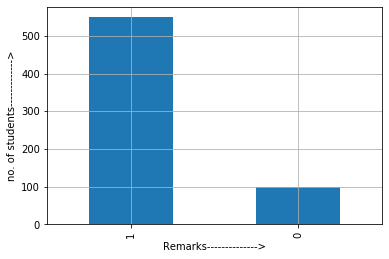

In [0]:
plt.xlabel('Remarks-------------->')
plt.ylabel('no. of students------------->')
pd.Series(Y).value_counts().plot(kind='bar')
plt.grid(True)
plt.show()

In [0]:
"""
# Import ML packages
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

#Y = df_c.pop('b_class')
X = df_c

# Preprocessing the data
scaled_data =  StandardScaler().fit(X).transform(X)

# create an instance of ExtraTreesClassifier
model =  ExtraTreesRegressor()

# divide the dataset in training set and testing set
X_train, X_test, Y_train, Y_test = train_test_split(scaled_data,Y,test_size=.25)

# train your model using train set
model.fit(X_train,Y_train)


# test your model using test set
y_pred = model.predict(X_test)
"""

"\n# Import ML packages\nfrom sklearn.ensemble import ExtraTreesRegressor\nfrom sklearn.svm import SVC\nfrom sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold\nfrom sklearn.metrics import accuracy_score\nfrom sklearn.preprocessing import StandardScaler\n\n#Y = df_c.pop('b_class')\nX = df_c\n\n# Preprocessing the data\nscaled_data =  StandardScaler().fit(X).transform(X)\n\n# create an instance of ExtraTreesClassifier\nmodel =  ExtraTreesRegressor()\n\n# divide the dataset in training set and testing set\nX_train, X_test, Y_train, Y_test = train_test_split(scaled_data,Y,test_size=.25)\n\n# train your model using train set\nmodel.fit(X_train,Y_train)\n\n\n# test your model using test set\ny_pred = model.predict(X_test)\n"

In [0]:
X.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

In [0]:
"""kf = KFold(n_splits=5)
# Preprocessing the data
scaled_data =  StandardScaler().fit(X).transform(X)

# create an instance of ExtraTreesClassifier
model =  ExtraTreesRegressor()

# divide the dataset in training set and testing set
X_train, X_test, Y_train, Y_test = train_test_split(scaled_data,Y,test_size=.3)

# Hyperparameter tuning
# No. of trees in ExtraTreesClassifier
n_estimators = [int(x) for x in np.linspace(start=10,stop=500,num=15)]
print(n_estimators)

# No. of features to consider  at every split
max_features = ['auto','sqrt','log2',None]
print(max_features)

# Maxm no. of levels in tree
max_depth = [int(i) for i in np.linspace(start=10,stop=150)]
max_depth.append(None)
print(max_depth)

#Minm no. of samples to split a node
min_samples_split=[2,3,4,5,10,12]

# Minm no. of samples required at each leaf node
min_samples_leaf = [1,2,4]

# methods for selecting samples for traning  each tree
bootstrap = [True,False]

criterion_range = ['gini','entropy']

# create param_grid
param_grid = dict(n_estimators = n_estimators,
                 max_features = max_features,
                 max_depth = max_depth,
                 min_samples_split = min_samples_split,
                 min_samples_leaf = min_samples_leaf,
                 bootstrap = bootstrap,
                  criterion=criterion_range)

print (param_grid)

# cross validation using RandomizedSearchCV
rscv =  RandomizedSearchCV(model,param_grid,cv=kf,scoring='accuracy')

# train your model using train set
model.fit(X_train,Y_train)


# test your model using test set
y_pred = model.predict(X_test)
"""

"kf = KFold(n_splits=5)\n# Preprocessing the data\nscaled_data =  StandardScaler().fit(X).transform(X)\n\n# create an instance of ExtraTreesClassifier\nmodel =  ExtraTreesRegressor()\n\n# divide the dataset in training set and testing set\nX_train, X_test, Y_train, Y_test = train_test_split(scaled_data,Y,test_size=.3)\n\n# Hyperparameter tuning\n# No. of trees in ExtraTreesClassifier\nn_estimators = [int(x) for x in np.linspace(start=10,stop=500,num=15)]\nprint(n_estimators)\n\n# No. of features to consider  at every split\nmax_features = ['auto','sqrt','log2',None]\nprint(max_features)\n\n# Maxm no. of levels in tree\nmax_depth = [int(i) for i in np.linspace(start=10,stop=150)]\nmax_depth.append(None)\nprint(max_depth)\n\n#Minm no. of samples to split a node\nmin_samples_split=[2,3,4,5,10,12]\n\n# Minm no. of samples required at each leaf node\nmin_samples_leaf = [1,2,4]\n\n# methods for selecting samples for traning  each tree\nbootstrap = [True,False]\n\ncriterion_range = ['gini','e

### ploting graph for binary classification with feature importance

In [0]:
"""# feature importance
x,y =[],[]
#etc.fit(X_train,Y_train)
f = list(zip(df.columns,model.feature_importances_))
k  = lambda s: s[1]
f = sorted(f,key=k,reverse=True)
for i,j in f:
  y.append(i)
  x.append(j)

# plot graph
plt.figure(figsize=(12,6))
plt.title("feature Importance")
plt.xlabel("Relative Importance")
plt.ylabel("Features")
plt.barh(y,x,height=.8,color='g')

plt.show()"""

'# feature importance\nx,y =[],[]\n#etc.fit(X_train,Y_train)\nf = list(zip(df.columns,model.feature_importances_))\nk  = lambda s: s[1]\nf = sorted(f,key=k,reverse=True)\nfor i,j in f:\n  y.append(i)\n  x.append(j)\n\n# plot graph\nplt.figure(figsize=(12,6))\nplt.title("feature Importance")\nplt.xlabel("Relative Importance")\nplt.ylabel("Features")\nplt.barh(y,x,height=.8,color=\'g\')\n\nplt.show()'

# 5-Level Classification
<table>
  <tr>
    <th>Group</th>
    <th>Marks</th>
    <th>Remarks</th>
  </tr>

  <tr>
    <td>1</td>
    <td>16-20</td>
    <td>Excellent</td>
  </tr>

  <tr>
    <td>2</td>
    <td>14-15</td>
    <td>Good</td>
  </tr>

  <tr>
    <td>3</td>
    <td>12-13</td>
    <td>Satisfactory</td>
  </tr>

  <tr>
    <td>4</td>
    <td>10-11</td>
    <td>Sufficient</td>
  </tr>

  <tr>
    <td>5</td>
    <td>0-9</td>
    <td>Fail</td>
  </tr>

</table>

In [0]:
X = df_c
Y = df_c.G3.apply(convert2)

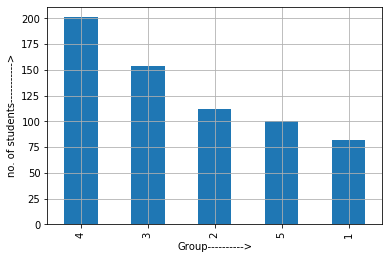

In [0]:
pd.Series(Y).value_counts().plot(kind='bar')
plt.xlabel('Group---------->')
plt.ylabel('no. of students----------->')
plt.grid(True)
plt.show()

### 5-level classification using RandomForestClassifier

In [0]:
X.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,0,0,0,4,4,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,4,3,4,1,1,3,4,0,11,11
1,0,0,17,0,0,1,1,1,0,1,0,1,1,2,0,1,1,0,0,1,0,1,0,5,3,3,1,1,3,2,9,11,11
2,0,0,15,0,1,1,1,1,0,1,1,0,1,2,0,0,0,0,0,0,0,1,0,4,3,2,2,3,3,6,12,13,12
3,0,0,15,0,0,1,4,2,1,2,2,0,1,3,0,1,1,0,1,0,0,1,1,3,2,2,1,1,5,0,14,14,14
4,0,0,16,0,0,1,3,3,2,1,2,1,1,2,0,1,1,0,0,0,0,0,0,4,3,2,1,2,5,0,11,13,13


In [0]:

# Preprocessing the data
scaled_data =  StandardScaler().fit(X).transform(X)

# create an instance of catboost model
model =  CatBoostClassifier()

# divide the dataset in training set and testing set
X_train, X_test, Y_train, Y_test = train_test_split(scaled_data,Y,test_size=.25)

# train your model using train set
model.fit(X_train,Y_train)


# test your model using test set
y_pred = model.predict(X_test)
print('training accuracy',model.score(X_train,Y_train))
print('testing accuracy',model.score(X_test,Y_test))


0:	learn: 1.5480886	total: 5.02ms	remaining: 5.02s
1:	learn: 1.4962157	total: 8.93ms	remaining: 4.46s
2:	learn: 1.4265957	total: 13ms	remaining: 4.32s
3:	learn: 1.3634597	total: 17ms	remaining: 4.23s
4:	learn: 1.2994645	total: 21.7ms	remaining: 4.31s
5:	learn: 1.2417167	total: 26.1ms	remaining: 4.33s
6:	learn: 1.1894583	total: 30ms	remaining: 4.25s
7:	learn: 1.1455012	total: 34.1ms	remaining: 4.23s
8:	learn: 1.1013796	total: 38.4ms	remaining: 4.23s
9:	learn: 1.0484984	total: 42.7ms	remaining: 4.23s
10:	learn: 1.0032482	total: 47.2ms	remaining: 4.24s
11:	learn: 0.9593633	total: 50.9ms	remaining: 4.19s
12:	learn: 0.9192371	total: 54.9ms	remaining: 4.17s
13:	learn: 0.8838465	total: 58.9ms	remaining: 4.14s
14:	learn: 0.8567521	total: 63.2ms	remaining: 4.15s
15:	learn: 0.8244726	total: 67.4ms	remaining: 4.14s
16:	learn: 0.7963713	total: 71.6ms	remaining: 4.14s
17:	learn: 0.7726084	total: 75.7ms	remaining: 4.13s
18:	learn: 0.7439997	total: 79.8ms	remaining: 4.12s
19:	learn: 0.7179452	total: 

In [0]:
"""# feature importance
x,y =[],[]
#etc.fit(X_train,Y_train)
f = list(zip(df.columns,model.feature_importances_))
k  = lambda s: s[1]
f = sorted(f,key=k,reverse=True)
for i,j in f:
  y.append(i)
  x.append(j)

# plot graph
plt.figure(figsize=(12,6))
plt.title("feature Importance")
plt.xlabel("Relative Importance")
plt.ylabel("Features")
plt.barh(y,x,height=.8,color='g')

plt.show()

'# feature importance\nx,y =[],[]\n#etc.fit(X_train,Y_train)\nf = list(zip(df.columns,model.feature_importances_))\nk  = lambda s: s[1]\nf = sorted(f,key=k,reverse=True)\nfor i,j in f:\n  y.append(i)\n  x.append(j)\n\n# plot graph\nplt.figure(figsize=(12,6))\nplt.title("feature Importance")\nplt.xlabel("Relative Importance")\nplt.ylabel("Features")\nplt.barh(y,x,height=.8,color=\'g\')\n\nplt.show()'

In [0]:
"""kf = KFold(n_splits=5)
# Preprocessing the data
scaled_data =  StandardScaler().fit(X).transform(X)

# create an instance of ExtraTreesClassifier
model =  ExtraTreesRegressor()

# divide the dataset in training set and testing set
X_train, X_test, Y_train, Y_test = train_test_split(scaled_data,Y,test_size=.3)

# Hyperparameter tuning
# No. of trees in ExtraTreesClassifier
n_estimators = [int(x) for x in np.linspace(start=10,stop=500,num=15)]
print(n_estimators)

# No. of features to consider  at every split
max_features = ['auto','sqrt','log2',None]
print(max_features)

# Maxm no. of levels in tree
max_depth = [int(i) for i in np.linspace(start=10,stop=150)]
max_depth.append(None)
print(max_depth)

#Minm no. of samples to split a node
min_samples_split=[2,3,4,5,10,12]

# Minm no. of samples required at each leaf node
min_samples_leaf = [1,2,4]

# methods for selecting samples for traning  each tree
bootstrap = [True,False]

#criterion_range = ['gini','entropy']

# create param_grid
param_grid = dict(n_estimators = n_estimators,
                 max_features = max_features,
                 max_depth = max_depth,
                 min_samples_split = min_samples_split,
                 min_samples_leaf = min_samples_leaf,
                 bootstrap = bootstrap,
                )

print (param_grid)

# cross validation using RandomizedSearchCV
rscv =  RandomizedSearchCV(model,param_grid,cv=kf,scoring='accuracy')

# train your model using train set
rscv.fit(X_train,Y_train)


# test your model using test set
y_pred = rscv.predict(X_test)
"""

"kf = KFold(n_splits=5)\n# Preprocessing the data\nscaled_data =  StandardScaler().fit(X).transform(X)\n\n# create an instance of ExtraTreesClassifier\nmodel =  ExtraTreesRegressor()\n\n# divide the dataset in training set and testing set\nX_train, X_test, Y_train, Y_test = train_test_split(scaled_data,Y,test_size=.3)\n\n# Hyperparameter tuning\n# No. of trees in ExtraTreesClassifier\nn_estimators = [int(x) for x in np.linspace(start=10,stop=500,num=15)]\nprint(n_estimators)\n\n# No. of features to consider  at every split\nmax_features = ['auto','sqrt','log2',None]\nprint(max_features)\n\n# Maxm no. of levels in tree\nmax_depth = [int(i) for i in np.linspace(start=10,stop=150)]\nmax_depth.append(None)\nprint(max_depth)\n\n#Minm no. of samples to split a node\nmin_samples_split=[2,3,4,5,10,12]\n\n# Minm no. of samples required at each leaf node\nmin_samples_leaf = [1,2,4]\n\n# methods for selecting samples for traning  each tree\nbootstrap = [True,False]\n\n#criterion_range = ['gini','

In [0]:
"""# No. of trees in ExtraTreesClassifier
n_estimators = [int(x) for x in np.linspace(start=10,stop=500,num=15)]
print(n_estimators)

# No. of features to consider  at every split
max_features = ['auto','sqrt','log2',None]
print(max_features)

# Maxm no. of levels in tree
max_depth = [int(i) for i in np.linspace(start=10,stop=150)]
max_depth.append(None)
print(max_depth)

#Minm no. of samples to split a node
min_samples_split=[2,3,4,5,10,12]

# Minm no. of samples required at each leaf node
min_samples_leaf = [1,2,4]

# methods for selecting samples for traning  each tree
bootstrap = [True,False]

criterion_range = ['mae','mse']

# create param_grid
param_grid = dict(n_estimators = n_estimators,
                 max_features = max_features,
                 max_depth = max_depth,
                 min_samples_split = min_samples_split,
                 min_samples_leaf = min_samples_leaf,
                 bootstrap = bootstrap,
                  criterion=criterion_range)

print (param_grid)

# cross validation using RandomizedSearchCV
rscv =  RandomizedSearchCV(model,param_grid,cv=kf,scoring='accuracy')"""

"# No. of trees in ExtraTreesClassifier\nn_estimators = [int(x) for x in np.linspace(start=10,stop=500,num=15)]\nprint(n_estimators)\n\n# No. of features to consider  at every split\nmax_features = ['auto','sqrt','log2',None]\nprint(max_features)\n\n# Maxm no. of levels in tree\nmax_depth = [int(i) for i in np.linspace(start=10,stop=150)]\nmax_depth.append(None)\nprint(max_depth)\n\n#Minm no. of samples to split a node\nmin_samples_split=[2,3,4,5,10,12]\n\n# Minm no. of samples required at each leaf node\nmin_samples_leaf = [1,2,4]\n\n# methods for selecting samples for traning  each tree\nbootstrap = [True,False]\n\ncriterion_range = ['mae','mse']\n\n# create param_grid\nparam_grid = dict(n_estimators = n_estimators,\n                 max_features = max_features,\n                 max_depth = max_depth,\n                 min_samples_split = min_samples_split,\n                 min_samples_leaf = min_samples_leaf,\n                 bootstrap = bootstrap,\n                  criterion=cr

# Regression

In [0]:

#Y = df_c.pop('G3')
X = df_c
# Preprocessing the data
scaled_data =  StandardScaler().fit(X).transform(X)

# create an instance of catboost model
model =  CatBoostRegressor(iterations=500)

# divide the dataset in training set and testing set
X_train, X_test, Y_train, Y_test = train_test_split(scaled_data,Y,test_size=.2)

# train your model using train set
model.fit(X_train,Y_train)

y_pred = model.predict(X_test)

0:	learn: 1.2194516	total: 1.96ms	remaining: 978ms
1:	learn: 1.1905868	total: 3.75ms	remaining: 934ms
2:	learn: 1.1616935	total: 5.33ms	remaining: 883ms
3:	learn: 1.1386784	total: 6.88ms	remaining: 853ms
4:	learn: 1.1133506	total: 8.58ms	remaining: 849ms
5:	learn: 1.0898017	total: 10.3ms	remaining: 846ms
6:	learn: 1.0666826	total: 12.2ms	remaining: 861ms
7:	learn: 1.0410084	total: 14ms	remaining: 861ms
8:	learn: 1.0217416	total: 15.7ms	remaining: 859ms
9:	learn: 0.9972488	total: 17.4ms	remaining: 851ms
10:	learn: 0.9732187	total: 19.2ms	remaining: 852ms
11:	learn: 0.9530284	total: 20.8ms	remaining: 845ms
12:	learn: 0.9306575	total: 22.3ms	remaining: 837ms
13:	learn: 0.9082386	total: 23.9ms	remaining: 830ms
14:	learn: 0.8886510	total: 25.6ms	remaining: 829ms
15:	learn: 0.8673708	total: 27.5ms	remaining: 831ms
16:	learn: 0.8463578	total: 30.4ms	remaining: 863ms
17:	learn: 0.8286756	total: 32.1ms	remaining: 859ms
18:	learn: 0.8096840	total: 33.6ms	remaining: 851ms
19:	learn: 0.7942255	tot

In [0]:
print(r2_score(Y_test,y_pred))

0.9979658604319094


In [0]:
np.sqrt(mean_squared_error(Y_test,y_pred))

0.05728196571002629

In [0]:
"""# feature importance
x,y =[],[]
#etc.fit(X_train,Y_train)
f = list(zip(X.columns,model.feature_importances_))
k  = lambda s: s[1]
f = sorted(f,key=k,reverse=True)
for i,j in f:
  y.append(i)
  x.append(j)

# plot graph
plt.figure(figsize=(12,6))
plt.title("feature Importance")
plt.xlabel("Relative Importance")
plt.ylabel("Features")
plt.barh(y,x,height=.8,color='g')

plt.show()"""

'# feature importance\nx,y =[],[]\n#etc.fit(X_train,Y_train)\nf = list(zip(X.columns,model.feature_importances_))\nk  = lambda s: s[1]\nf = sorted(f,key=k,reverse=True)\nfor i,j in f:\n  y.append(i)\n  x.append(j)\n\n# plot graph\nplt.figure(figsize=(12,6))\nplt.title("feature Importance")\nplt.xlabel("Relative Importance")\nplt.ylabel("Features")\nplt.barh(y,x,height=.8,color=\'g\')\n\nplt.show()'

# Thank you 
Any query:-<br>
Email id: hbr8218@gmail.com